# Earnings Impact on Stocks and Options 

Aspiring to contribute my expertise in data analysis, Python programming, web scraping, and options trading, I embarked on a comprehensive project that not only showcases my technical prowess but also demonstrates my genuine passion for the intricacies of financial markets. This project is designed to illustrate my ability to harness data to extract valuable insights.

### Methodology

My approach to this project encompassed a multi-faceted data-driven methodology:

1. **Web Scraping**: To gather the essential historical data on the AAPL stock and earnings releases, I employed web scraping techniques. This not only honed my skills in data acquisition but also provided me with real-world experience in handling unstructured data.

2. **Data Cleaning and Processing**: The acquired data, while valuable, required meticulous cleaning and processing. This step showcases my proficiency in data preparation.

3. **Data Analysis**: Armed with a clean dataset, I delved into the heart of the matter: the relationship between earnings releases, stock prices, implied volatility, and options pricing. 

4. **Data Visualization**: To effectively understand the data, I utilized various data visualization techniques. This included creating insightful charts, graphs, and plots to visually represent trends, patterns, and correlations within the data. Data visualization not only enhances the clarity of the analysis but also underscores my proficiency in conveying complex information in a digestible format.



### Import the necessary libraries

In [1]:
import yfinance as yf
from bs4 import BeautifulSoup
import requests


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns  
pd.set_option('display.max_columns', 100) 

### Define the symbol to be analized and the study period

In [2]:
symbol = 'AAPL'
start = '2016-01-04'
end = '2023-03-31'

### Get stock historical data

In [3]:
ticker = yf.Ticker(symbol)
prices_df = ticker.history(start=start, end=end, actions=False, rounding=True)

# The study will center on Open and Closing prices, so I do not need High and Low prices
prices_df.drop(columns='High', inplace=True)
prices_df.drop(columns='Low', inplace=True)

# Convert the date column to the Pandas datetime format and use it as index
prices_df.reset_index(inplace=True)
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df.set_index('Date', inplace=True)
prices_df.head()

,Open,Close,Volume
Date,,,
2016-01-04,23.38,24.01,270597600
2016-01-05,24.10,23.41,223164000
2016-01-06,22.92,22.95,273829600
2016-01-07,22.49,21.98,324377600
2016-01-08,22.46,22.10,283192000


In [4]:
# Add columns with important information 
prices_df['Close Previous Day'] = prices_df['Close'].shift(1)
prices_df['Open Following Day'] = prices_df['Open'].shift(-1)
prices_df['Volume Previous Day'] = prices_df['Volume'].shift(1)
prices_df['Volume Following Day'] = prices_df['Volume'].shift(-1)
prices_df.head()

,Open,Close,Volume,Close Previous Day,Open Following Day,Volume Previous Day,Volume Following Day
Date,,,,,,,
2016-01-04,23.38,24.01,270597600,NaN,24.10,NaN,223164000.0
2016-01-05,24.10,23.41,223164000,24.01,22.92,270597600.0,273829600.0
2016-01-06,22.92,22.95,273829600,23.41,22.49,223164000.0,324377600.0
2016-01-07,22.49,21.98,324377600,22.95,22.46,273829600.0,283192000.0
2016-01-08,22.46,22.10,283192000,21.98,22.56,324377600.0,198957600.0


### Retrieve Earnings Release Dates and Associated Information

In [5]:
def scrape_earnings_data(stock_symbol):
    # URL of the page to scrape
    url = f"https://www.alphaquery.com/stock/{stock_symbol}/earnings-history"

    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the table containing the earnings data
    earnings_table = soup.find("table", {"class": "table table-bordered table-striped table-basic"})

    # Initialize lists to store data
    dates = []
    fiscal = []
    eps_estimates = []
    eps_actual = []

    # Iterate through rows in the table
    for row in earnings_table.find_all("tr")[1:]:
        cols = row.find_all("td")
        dates.append(cols[0].text.strip())
        
        eps_estimates.append(cols[2].text.strip())
        eps_actual.append(cols[3].text.strip())

    # Create a pandas DataFrame
    earnings_df = pd.DataFrame({
        "Date": dates,
        "Estimated EPS": eps_estimates,
        "Actual EPS": eps_actual
    })

    return earnings_df


earnings_df = scrape_earnings_data(symbol)

earnings_df['Date'] = pd.to_datetime(earnings_df['Date']).dt.date
earnings_df.set_index('Date', inplace=True)
earnings_df["Surprise"] = earnings_df["Actual EPS"].str.lstrip('$').astype(float) - earnings_df["Estimated EPS"].str.lstrip('$').astype(float)
earnings_df.head()

,Estimated EPS,Actual EPS,Surprise
Date,,,
2023-08-03,$1.19,$1.26,0.07
2023-05-04,$1.44,$1.52,0.08
2023-02-02,$1.93,$1.88,-0.05
2022-10-27,$1.26,$1.29,0.03
2022-07-28,$1.14,$1.20,0.06


### Merge the stock historical data and the earning releases dataframes

In [6]:
df_temp = pd.merge(earnings_df,prices_df, how='inner', on='Date')
df_temp.head()

,Estimated EPS,Actual EPS,Surprise,Open,Close,Volume,Close Previous Day,Open Following Day,Volume Previous Day,Volume Following Day
Date,,,,,,,,,,
2023-02-02,$1.93,$1.88,-0.05,148.27,150.18,118339000,144.81,147.40,77663600.0,154357300.0
2022-10-27,$1.26,$1.29,0.03,147.20,143.95,109180200,148.47,147.33,88194300.0,164762400.0
2022-07-28,$1.14,$1.20,0.06,155.84,156.21,81378700,155.65,160.07,78620700.0,101786900.0
2022-04-28,$1.43,$1.52,0.09,157.86,162.21,130216800,155.20,160.43,88063200.0,131747600.0
2022-01-27,$1.89,$2.10,0.21,160.83,157.63,121954600,158.09,164.05,108275300.0,179935700.0


### Retrieve VIX historical data

In [7]:
# Define ticker and time period
vix = yf.Ticker('^VIX')
vix_df = vix.history(start=start, end=end, actions=False, rounding=True)

# The study will only need the VIX mean value during the day, so only the high and low values are relevant
vix_df.drop(columns= 'Volume', inplace=True)
vix_df.drop(columns='Close', inplace=True)
vix_df.drop(columns='Open', inplace=True)



# Convert the date column to the Pandas datetime format and use it as index
vix_df.reset_index(inplace=True)
vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.date
vix_df.set_index('Date', inplace=True)

# Calculate the mean VIX value during the day and 
mean_vix = vix_df.mean(axis=1)
vix_df['Mean'] = mean_vix
vix_df = vix_df.add_suffix('_VIX')

vix_df.head()

,High_VIX,Low_VIX,Mean_VIX
Date,,,
2016-01-04,23.36,20.67,22.015
2016-01-05,21.06,19.25,20.155
2016-01-06,21.86,19.80,20.830
2016-01-07,25.86,22.40,24.130
2016-01-08,27.08,22.48,24.780


### Add the VIX data to the main dataframe

In [8]:
# Merge the Vix data with the stock data frame 
df = pd.merge(df_temp,vix_df, how='left', on='Date')

# The  high and low VIX values are now longer relevant
df.drop(columns=['High_VIX','Low_VIX'],inplace=True)

df.head()


,Estimated EPS,Actual EPS,Surprise,Open,Close,Volume,Close Previous Day,Open Following Day,Volume Previous Day,Volume Following Day,Mean_VIX
Date,,,,,,,,,,,
2023-02-02,$1.93,$1.88,-0.05,148.27,150.18,118339000,144.81,147.40,77663600.0,154357300.0,18.155
2022-10-27,$1.26,$1.29,0.03,147.20,143.95,109180200,148.47,147.33,88194300.0,164762400.0,27.305
2022-07-28,$1.14,$1.20,0.06,155.84,156.21,81378700,155.65,160.07,78620700.0,101786900.0,22.880
2022-04-28,$1.43,$1.52,0.09,157.86,162.21,130216800,155.20,160.43,88063200.0,131747600.0,30.000
2022-01-27,$1.89,$2.10,0.21,160.83,157.63,121954600,158.09,164.05,108275300.0,179935700.0,30.710


### Calculate percentage price change between closing and next Opening

In [9]:
# Calculate the percentage of price change before and after the earnings releases
pct = ((df['Open Following Day']-df['Close'])/df['Close'])*100
df['Price Change %'] = round(pct,2)
df.head()

,Estimated EPS,Actual EPS,Surprise,Open,Close,Volume,Close Previous Day,Open Following Day,Volume Previous Day,Volume Following Day,Mean_VIX,Price Change %
Date,,,,,,,,,,,,
2023-02-02,$1.93,$1.88,-0.05,148.27,150.18,118339000,144.81,147.40,77663600.0,154357300.0,18.155,-1.85
2022-10-27,$1.26,$1.29,0.03,147.20,143.95,109180200,148.47,147.33,88194300.0,164762400.0,27.305,2.35
2022-07-28,$1.14,$1.20,0.06,155.84,156.21,81378700,155.65,160.07,78620700.0,101786900.0,22.880,2.47
2022-04-28,$1.43,$1.52,0.09,157.86,162.21,130216800,155.20,160.43,88063200.0,131747600.0,30.000,-1.10
2022-01-27,$1.89,$2.10,0.21,160.83,157.63,121954600,158.09,164.05,108275300.0,179935700.0,30.710,4.07


### Calculate percentage volume change between trading days

In [10]:
# Calculate the percentage of volume change before and after the earnings releases
pct = ((df['Volume Following Day']-df['Volume'])/df['Volume'])*100
df['Volume Change %'] = round(pct,2)
df.head()



,Estimated EPS,Actual EPS,Surprise,Open,Close,Volume,Close Previous Day,Open Following Day,Volume Previous Day,Volume Following Day,Mean_VIX,Price Change %,Volume Change %
Date,,,,,,,,,,,,,
2023-02-02,$1.93,$1.88,-0.05,148.27,150.18,118339000,144.81,147.40,77663600.0,154357300.0,18.155,-1.85,30.44
2022-10-27,$1.26,$1.29,0.03,147.20,143.95,109180200,148.47,147.33,88194300.0,164762400.0,27.305,2.35,50.91
2022-07-28,$1.14,$1.20,0.06,155.84,156.21,81378700,155.65,160.07,78620700.0,101786900.0,22.880,2.47,25.08
2022-04-28,$1.43,$1.52,0.09,157.86,162.21,130216800,155.20,160.43,88063200.0,131747600.0,30.000,-1.10,1.18
2022-01-27,$1.89,$2.10,0.21,160.83,157.63,121954600,158.09,164.05,108275300.0,179935700.0,30.710,4.07,47.54


### Retrieve options chain data

This information is available at https://www.kaggle.com/datasets/kylegraupe/aapl-options-data-2016-2020

In [11]:
# Read csv files containing options data
options_df1 = pd.read_csv('./APPL_options_data/aapl_2021_2023.csv',low_memory=False)
options_df2 = pd.read_csv('./APPL_options_data/aapl_2016_2020.csv', low_memory=False)


In [12]:
# Concatenate both data frames
options_df = pd.concat([options_df1, options_df2], axis=0)
options_df

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[P_BID],[P_ASK],[P_SIZE],[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,,,0.000000,16 x 16,68.800000,68.950000,70.0,0.000000,0.010000,0 x 410,0.020000,-0.00093,0.00004,0.00011,-0.00547,0.0,4.889460,0.000000,68.9,0.496
1,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,,,0.000000,1 x 1,63.750000,63.950000,75.0,0.000000,0.010000,0 x 397,0.010000,-0.00066,0.00001,0.00061,-0.00491,0.0,4.422080,0.000000,63.9,0.460
2,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,,,0.000000,1 x 1,58.750000,58.950000,80.0,0.000000,0.010000,0 x 612,0.010000,-0.00108,0.00009,-0.00012,-0.00455,0.0,3.984220,0.000000,58.9,0.424
3,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,0.000010,6.000000,53.160000,1 x 4,52.100000,55.700000,85.0,0.000000,0.010000,0 x 396,0.010000,-0.001,0.00015,-0.00018,-0.00525,0.0,3.571790,0.000000,53.9,0.388
4,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,0.99404,0.00067,0.00113,-0.05027,0.00173,3.969420,7.000000,47.300000,86 x 19,47.500000,50.400000,90.0,0.000000,0.010000,0 x 403,0.010000,-0.00138,0.00014,0.00025,-0.00453,0.0,3.180820,0.000000,48.9,0.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015347,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.227860,0.006980,0.580380,-0.009190,0.490070,0.224350,12.000000,5.400000,266 x 332,4.700000,5.260000,185.0,44.950000,46.810000,394 x 517,0.000000,-0.829940,0.006920,0.461460,-0.008700,-2.973100,0.177380,,41.3,0.288
1015348,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.197850,0.006560,0.535880,-0.008610,0.431340,0.220950,1.000000,4.230000,122 x 2,3.890000,4.340000,190.0,48.440000,51.100000,393 x 350,0.000000,-0.880600,0.005750,0.351070,-0.007180,-3.177300,0.161320,,46.3,0.322
1015349,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.175740,0.006000,0.496720,-0.007940,0.384330,0.221970,40.000000,3.480000,154 x 286,3.300000,3.800000,195.0,52.600000,55.440000,469 x 395,54.020000,-0.925010,0.004240,0.232920,-0.005370,-3.368870,0.145280,0.000000,51.3,0.357
1015350,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.150740,0.005560,0.450690,-0.006650,0.334300,0.219000,272.000000,2.900000,2 x 137,2.750000,3.100000,200.0,57.000000,60.100000,496 x 382,58.720000,-0.961490,0.002330,0.111140,-0.003600,-3.545580,0.124590,183.000000,56.3,0.392


### Perform data cleaning 

In [13]:
# Clean Column names eliminating undisired characters and spaces
column_names = options_df.columns.tolist()
column_names = [name.strip() for name in column_names]
column_names = [name.replace('[','') for name in column_names]
column_names = [name.replace(']','') for name in column_names]
options_df.columns = column_names
options_df

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
0,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,,,0.000000,16 x 16,68.800000,68.950000,70.0,0.000000,0.010000,0 x 410,0.020000,-0.00093,0.00004,0.00011,-0.00547,0.0,4.889460,0.000000,68.9,0.496
1,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,,,0.000000,1 x 1,63.750000,63.950000,75.0,0.000000,0.010000,0 x 397,0.010000,-0.00066,0.00001,0.00061,-0.00491,0.0,4.422080,0.000000,63.9,0.460
2,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,,,0.000000,1 x 1,58.750000,58.950000,80.0,0.000000,0.010000,0 x 612,0.010000,-0.00108,0.00009,-0.00012,-0.00455,0.0,3.984220,0.000000,58.9,0.424
3,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,1.0,0.0,0.0,0.0,0.0,0.000010,6.000000,53.160000,1 x 4,52.100000,55.700000,85.0,0.000000,0.010000,0 x 396,0.010000,-0.001,0.00015,-0.00018,-0.00525,0.0,3.571790,0.000000,53.9,0.388
4,1656705600,2022-07-01 16:00,2022-07-01,16.0,138.90,2022-07-01,1656705600,0.00,0.99404,0.00067,0.00113,-0.05027,0.00173,3.969420,7.000000,47.300000,86 x 19,47.500000,50.400000,90.0,0.000000,0.010000,0 x 403,0.010000,-0.00138,0.00014,0.00025,-0.00453,0.0,3.180820,0.000000,48.9,0.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015347,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.227860,0.006980,0.580380,-0.009190,0.490070,0.224350,12.000000,5.400000,266 x 332,4.700000,5.260000,185.0,44.950000,46.810000,394 x 517,0.000000,-0.829940,0.006920,0.461460,-0.008700,-2.973100,0.177380,,41.3,0.288
1015348,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.197850,0.006560,0.535880,-0.008610,0.431340,0.220950,1.000000,4.230000,122 x 2,3.890000,4.340000,190.0,48.440000,51.100000,393 x 350,0.000000,-0.880600,0.005750,0.351070,-0.007180,-3.177300,0.161320,,46.3,0.322
1015349,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.175740,0.006000,0.496720,-0.007940,0.384330,0.221970,40.000000,3.480000,154 x 286,3.300000,3.800000,195.0,52.600000,55.440000,469 x 395,54.020000,-0.925010,0.004240,0.232920,-0.005370,-3.368870,0.145280,0.000000,51.3,0.357
1015350,1490990400,2017-03-31 16:00,2017-03-31,16.0,143.67,2019-01-18,1547845200,658.04,0.150740,0.005560,0.450690,-0.006650,0.334300,0.219000,272.000000,2.900000,2 x 137,2.750000,3.100000,200.0,57.000000,60.100000,496 x 382,58.720000,-0.961490,0.002330,0.111140,-0.003600,-3.545580,0.124590,183.000000,56.3,0.392


In [14]:
# Eliminate unnecessary information
options_df = options_df.drop(columns=['QUOTE_UNIXTIME','QUOTE_TIME_HOURS','EXPIRE_UNIX','DTE','QUOTE_READTIME'])
options_df.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
0,2022-07-01,138.9,2022-07-01,1.0,0.0,0.0,0.0,0.0,,,0.000000,16 x 16,68.800000,68.950000,70.0,0.000000,0.010000,0 x 410,0.020000,-0.00093,0.00004,0.00011,-0.00547,0.0,4.889460,0.000000,68.9,0.496
1,2022-07-01,138.9,2022-07-01,1.0,0.0,0.0,0.0,0.0,,,0.000000,1 x 1,63.750000,63.950000,75.0,0.000000,0.010000,0 x 397,0.010000,-0.00066,0.00001,0.00061,-0.00491,0.0,4.422080,0.000000,63.9,0.460
2,2022-07-01,138.9,2022-07-01,1.0,0.0,0.0,0.0,0.0,,,0.000000,1 x 1,58.750000,58.950000,80.0,0.000000,0.010000,0 x 612,0.010000,-0.00108,0.00009,-0.00012,-0.00455,0.0,3.984220,0.000000,58.9,0.424
3,2022-07-01,138.9,2022-07-01,1.0,0.0,0.0,0.0,0.0,0.000010,6.000000,53.160000,1 x 4,52.100000,55.700000,85.0,0.000000,0.010000,0 x 396,0.010000,-0.001,0.00015,-0.00018,-0.00525,0.0,3.571790,0.000000,53.9,0.388
4,2022-07-01,138.9,2022-07-01,0.99404,0.00067,0.00113,-0.05027,0.00173,3.969420,7.000000,47.300000,86 x 19,47.500000,50.400000,90.0,0.000000,0.010000,0 x 403,0.010000,-0.00138,0.00014,0.00025,-0.00453,0.0,3.180820,0.000000,48.9,0.352


In [15]:
# Clean the data in every row
column_names = options_df.columns.tolist()
for i in range(0,3,2):
    options_df[column_names[i]] = options_df[column_names[i]].str.strip()

for i in range(3,11):
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace(' ','')
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace('',None)
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace('None',None)
    options_df[column_names[i]] = options_df[column_names[i]].astype(float)
    
for i in range(12,17):
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace(' ','')
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace('',None)
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace('None',None)
    options_df[column_names[i]] = options_df[column_names[i]].astype(float)
    
for i in range(18,26):
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace(' ','')
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace('',None)
    options_df[column_names[i]] = options_df[column_names[i]].astype(str).replace('None',None)
    options_df[column_names[i]] = options_df[column_names[i]].astype(float)



In [16]:
# Add a column with an ID name for every option to facilitate data identification
options_df['OPTION_ID'] = symbol + options_df['EXPIRE_DATE'].astype(str).str[:4] + options_df['EXPIRE_DATE'].astype(str).str[5:7] + options_df['EXPIRE_DATE'].astype(str).str[8:10]+'_'+options_df['STRIKE'].astype(str)
options_df.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,OPTION_ID
0,2022-07-01,138.9,2022-07-01,1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,0.00,16 x 16,68.80,68.95,70.0,0.0,0.01,0 x 410,0.02,-0.00093,0.00004,0.00011,-0.00547,0.0,4.88946,0.0,68.9,0.496,AAPL20220701_70.0
1,2022-07-01,138.9,2022-07-01,1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,0.00,1 x 1,63.75,63.95,75.0,0.0,0.01,0 x 397,0.01,-0.00066,0.00001,0.00061,-0.00491,0.0,4.42208,0.0,63.9,0.460,AAPL20220701_75.0
2,2022-07-01,138.9,2022-07-01,1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,0.00,1 x 1,58.75,58.95,80.0,0.0,0.01,0 x 612,0.01,-0.00108,0.00009,-0.00012,-0.00455,0.0,3.98422,0.0,58.9,0.424,AAPL20220701_80.0
3,2022-07-01,138.9,2022-07-01,1.00000,0.00000,0.00000,0.00000,0.00000,0.00001,6.0,53.16,1 x 4,52.10,55.70,85.0,0.0,0.01,0 x 396,0.01,-0.00100,0.00015,-0.00018,-0.00525,0.0,3.57179,0.0,53.9,0.388,AAPL20220701_85.0
4,2022-07-01,138.9,2022-07-01,0.99404,0.00067,0.00113,-0.05027,0.00173,3.96942,7.0,47.30,86 x 19,47.50,50.40,90.0,0.0,0.01,0 x 403,0.01,-0.00138,0.00014,0.00025,-0.00453,0.0,3.18082,0.0,48.9,0.352,AAPL20220701_90.0


### Calculate days to expiration

In [17]:
### Add a column for the days to expiration

options_df['EXPIRE_DATE'] = pd.to_datetime(options_df['EXPIRE_DATE'])
options_df['QUOTE_DATE'] = pd.to_datetime(options_df['QUOTE_DATE'])


options_df['DAYS_TO_EXPIRATION'] = (options_df['EXPIRE_DATE'] - options_df['QUOTE_DATE'])
options_df['DAYS_TO_EXPIRATION'] = options_df['DAYS_TO_EXPIRATION'].dt.days
options_df = options_df.sort_values(by='QUOTE_DATE')
options_df

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,OPTION_ID,DAYS_TO_EXPIRATION
757830,2016-01-04,105.35,2016-01-08,1.00000,0.00000,0.00000,0.00000,0.00000,0.00030,NaN,0.00,5 x 10,45.19,45.51,60.0,0.00,0.02,0 x 699,0.00,-0.00156,0.00024,0.00063,-0.00743,-0.00007,1.68940,NaN,45.3,0.430,AAPL20160108_60.0,4
758221,2016-01-04,105.35,2016-03-18,0.04423,0.00732,0.04537,-0.00769,0.00946,0.26853,387.0,0.22,733 x 363,0.22,0.24,130.0,25.14,25.40,786 x 1207,25.91,-0.95220,0.00725,0.04409,-0.01278,-0.25783,0.26732,87.0,24.7,0.234,AAPL20160318_130.0,74
758220,2016-01-04,105.35,2016-03-18,0.08082,0.01183,0.07193,-0.01244,0.01694,0.26411,367.0,0.43,364 x 38,0.43,0.45,125.0,20.34,20.66,633 x 1475,21.15,-0.91552,0.01182,0.07158,-0.01741,-0.24061,0.26506,29.0,19.7,0.187,AAPL20160318_125.0,74
758219,2016-01-04,105.35,2016-03-18,0.14422,0.01798,0.10863,-0.01858,0.02884,0.26453,NaN,0.89,136 x 40,0.87,0.89,120.0,15.79,15.99,7 x 920,15.93,-0.85653,0.01784,0.10633,-0.02338,-0.21823,0.26012,226.0,14.7,0.139,AAPL20160318_120.0,74
758218,2016-01-04,105.35,2016-03-18,0.24733,0.02442,0.15085,-0.02573,0.04915,0.27166,NaN,1.76,10 x 226,1.78,1.80,115.0,11.75,11.85,37 x 209,11.85,-0.75247,0.02444,0.14925,-0.03065,-0.18728,0.26878,NaN,9.7,0.092,AAPL20160318_115.0,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380752,2023-03-31,164.84,2023-05-12,0.89560,0.00748,0.09967,-0.05238,0.14122,0.41894,NaN,0.00,55 x 54,25.25,29.20,139.0,0.69,0.73,114 x 218,0.00,-0.07402,0.00683,0.07931,-0.03230,-0.01449,0.36440,NaN,25.8,0.157,AAPL20230512_139.0,42
380751,2023-03-31,164.84,2023-05-12,0.90114,0.00710,0.09594,-0.05085,0.14062,0.42698,NaN,0.00,3 x 8,26.20,30.15,138.0,0.63,0.67,276 x 112,0.00,-0.06752,0.00628,0.07412,-0.03116,-0.01341,0.36771,NaN,26.8,0.163,AAPL20230512_138.0,42
380750,2023-03-31,164.84,2023-05-12,0.90573,0.00667,0.09277,-0.05040,0.14083,0.43500,NaN,0.00,4 x 10,27.15,31.10,137.0,0.59,0.62,108 x 138,0.63,-0.06318,0.00590,0.07023,-0.02933,-0.01254,0.37365,3.0,27.8,0.169,AAPL20230512_137.0,42
380748,2023-03-31,164.84,2023-05-12,0.91391,0.00598,0.08631,-0.04830,0.14000,0.45052,1.0,29.10,6 x 10,29.05,33.00,135.0,0.50,0.54,164 x 19,0.56,-0.05376,0.00508,0.06232,-0.02720,-0.01141,0.38290,360.0,29.8,0.181,AAPL20230512_135.0,42


### Data Visualization

### Distribution of EPS Surprises

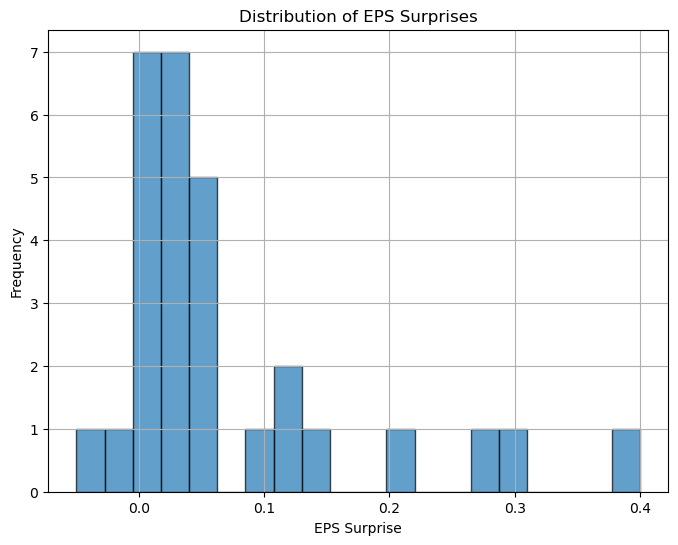

In [18]:
eps_surprises = df['Surprise']

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
plt.hist(eps_surprises, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('EPS Surprise')
plt.ylabel('Frequency')
plt.title('Distribution of EPS Surprises')
plt.grid(True)
plt.show()

**Key Insights:**

- The histogram shows that most EPS surprises fall within a specific range (-0.1 ~ 0.1), with a peak in the distribution.

- The chart helps understand that EPS surprises  have a slightly positively skewed distribution with a relatively narrow range of values. This suggests that, on average, actual earnings tend to slightly exceed estimates, but there is moderate variability in the surprises.


### Impact of the EPS Surprise on the stock prices

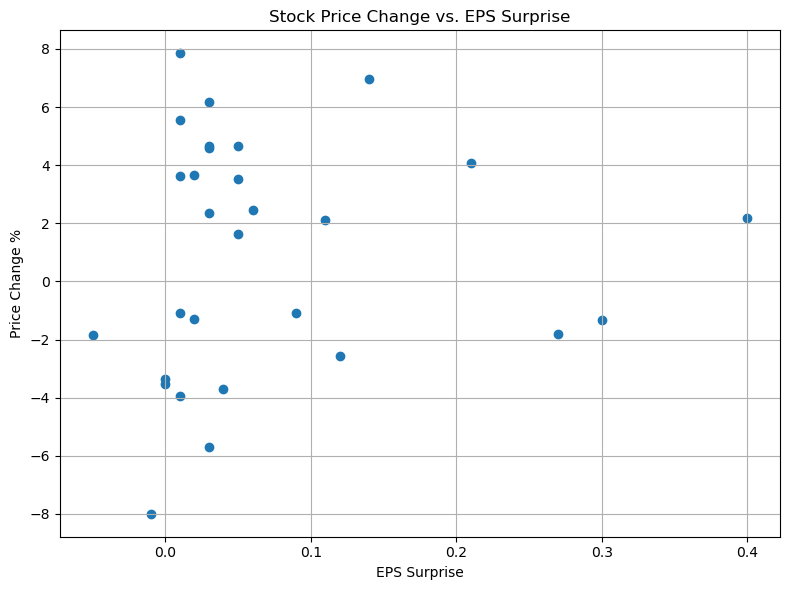

In [19]:
price_changes = df['Price Change %']

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(eps_surprises, price_changes)
plt.xlabel('EPS Surprise')
plt.ylabel('Price Change %')
plt.title('Stock Price Change vs. EPS Surprise')
plt.grid(True)
plt.tight_layout()
plt.show()

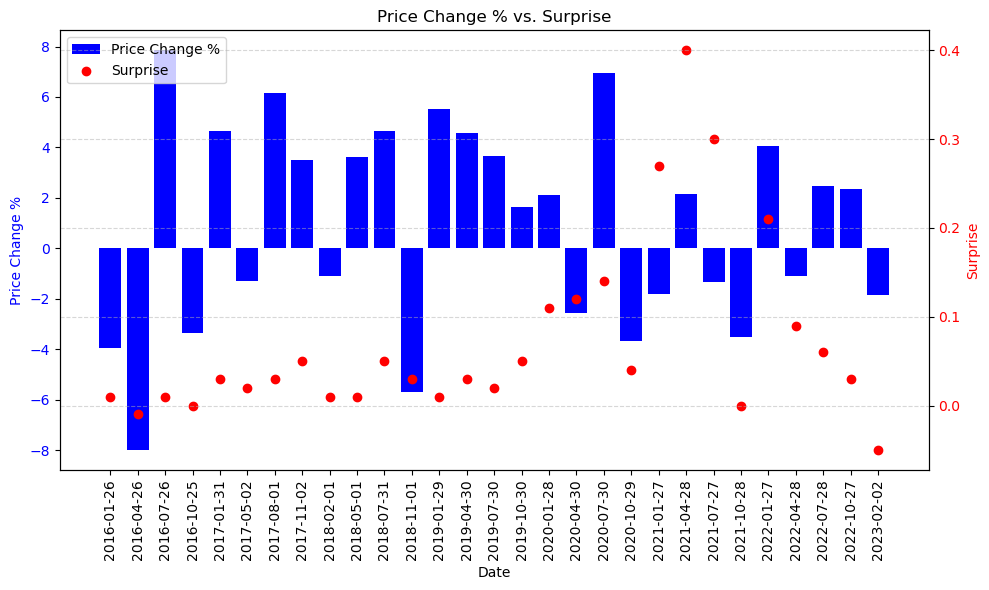

In [20]:
import warnings
warnings.filterwarnings('ignore')


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(df.index.astype(str), df['Price Change %'], color='blue', label='Price Change %')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price Change %', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the scatter plot
ax2 = ax1.twinx()
ax2.scatter(df.index.astype(str), df['Surprise'], color='red', marker='o', label='Surprise')
ax2.set_ylabel('Surprise', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

plt.title('Price Change % vs. Surprise')
# Rotate x-axis labels by 45 degrees
ax1.set_xticklabels(df.index.astype(str), rotation=90)

# Customize grid style
ax1.grid(True, linestyle='--', alpha=0)
ax2.grid(True, linestyle='--', alpha=0.5)

# Invert the x-axis
ax1.invert_xaxis()


plt.tight_layout()
plt.show()

**Key Insights:**

1. **Positive Surprise and Stock Price Increase:** It is observed that there are instances where a positive surprise corresponds to a positive percentage change in stock price  This suggests that when companies report earnings that exceed market expectations, investors often respond positively by bidding up the stock price.

2. **Negative Surprise and Stock Price Decrease:** Conversely, there are cases where a negative surprise corresponds to a negative percentage change in stock price. This indicates that when actual earnings fall short of estimates, it can lead to a decrease in the stock price as investors may sell off their positions.

3. **Mixed Outcomes:** Notably, there are instances where the relationship between surprise and stock price change does not follow the behaivor described above. This indicates that other factors, such as market sentiment, macroeconomic conditions, or company-specific news, can also influence stock price movements.

4. **Variance in Responses:** The data shows variability in how the market responds to earnings surprises. While some positive surprises lead to significant stock price increases, others may result in more modest gains. Similarly, negative surprises can lead to varying degrees of stock price declines.

Overall, the data suggests that there is a relationship between earnings surprises and stock price changes, with positive surprises generally associated with stock price increases and negative surprises linked to stock price decreases. However, this relationship is nuanced and influenced by various factors, making further analysis valuable for a more precise assessment of the impact of earnings surprises on stock prices.


### Correlation between EPS Surprise and the stock prices

In [21]:
# Calculate the correlation coefficient
correlation = df['Surprise'].corr(df['Price Change %'])

correlation

0.07861747648827194

**Interpretation of Correlation (r = 0.078):**

- The positive correlation coefficient (0.078) suggests a very weak positive linear relationship between "Surprise" and "Stock Price Change %." However, the correlation is close to zero, indicating that the relationship is extremely weak.

- In practical terms, a positive correlation coefficient of this magnitude implies that there is some minimal tendency for positive earnings surprises (higher "Surprise" values) to be associated with slightly higher stock price changes (positive "Stock Price Change %" values). However, the relationship is so weak that it may not be practically significant.

- It's essential to note that the correlation coefficient of 0.078 does not imply causation. It merely indicates a statistical association. Other factors and variables not considered in this analysis likely have a more substantial influence on stock price changes.


## Options Data Visualitazion

In [22]:
earnings_dates = earnings_df.index.to_list()

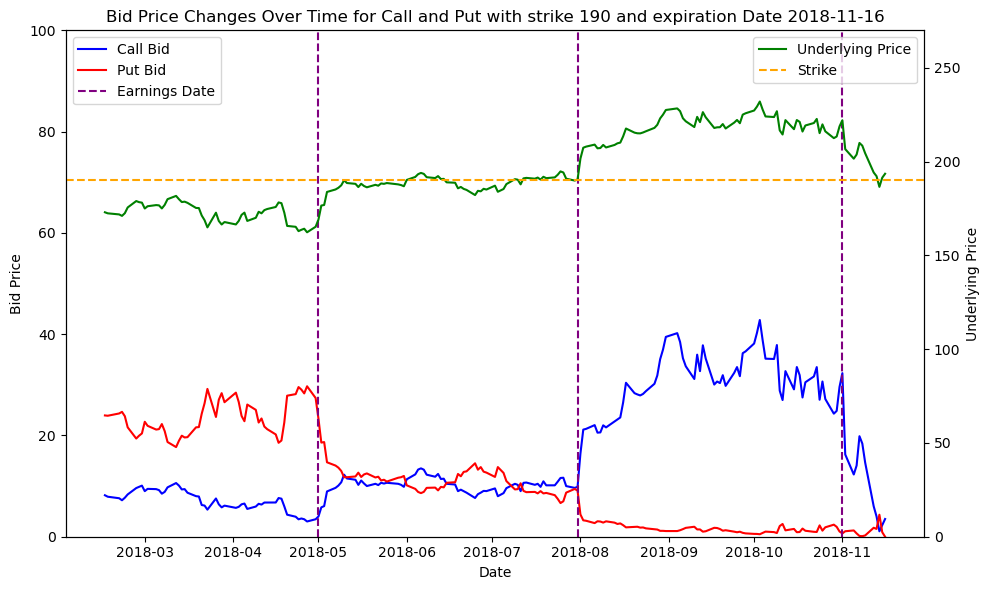

In [30]:
# Filter the DataFrame for the specific OPTION_ID
option_id = 'AAPL20181116_190.0'
filtered_df = options_df[options_df['OPTION_ID'] == option_id]

# Create a figure and the first subplot (left y-axis)
fig, ax1 = plt.subplots(figsize=(10, 6))


# Plotting the option bid prices on the left y-axis
ax1.plot(filtered_df['QUOTE_DATE'], filtered_df['C_BID'], linestyle='-', color='b', label='Call Bid')
ax1.plot(filtered_df['QUOTE_DATE'], filtered_df['P_BID'], linestyle='-', color='r', label='Put Bid')



label = 'yes'
for earning_date in earnings_dates:
    if str(earning_date) > '2018-03-01' and str(earning_date) < '2019-01-01':
        ax1.axvline(x=earning_date, color='purple', linestyle='--', label='Earnings Date' if label == 'yes' else None)
        label = 'no'

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Bid Price')
ax1.set_title(f'Bid Price Changes Over Time for Call and Put with strike 190 and expiration Date 2018-11-16')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

# Plot the underlying price on the right y-axis
ax2.plot(filtered_df['QUOTE_DATE'], filtered_df['UNDERLYING_LAST'], color='g', label='Underlying Price')
ax2.axhline(y=190, color='orange', linestyle='--', label='Strike')

# Set labels for the right y-axis
ax2.set_ylabel('Underlying Price')

# Set the legend for the right y-axis
ax2.legend(loc='upper right')

ax2.set_ylim(0, 270)
ax1.set_ylim(0, 100)


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Ensure the layout is tight
plt.tight_layout()

# Show the plot
plt.show()



# Show the plot
plt.show()

##### This is just a graph that allows to see the changes in value for Calls and Punts at a certain strike as the underlying price changes

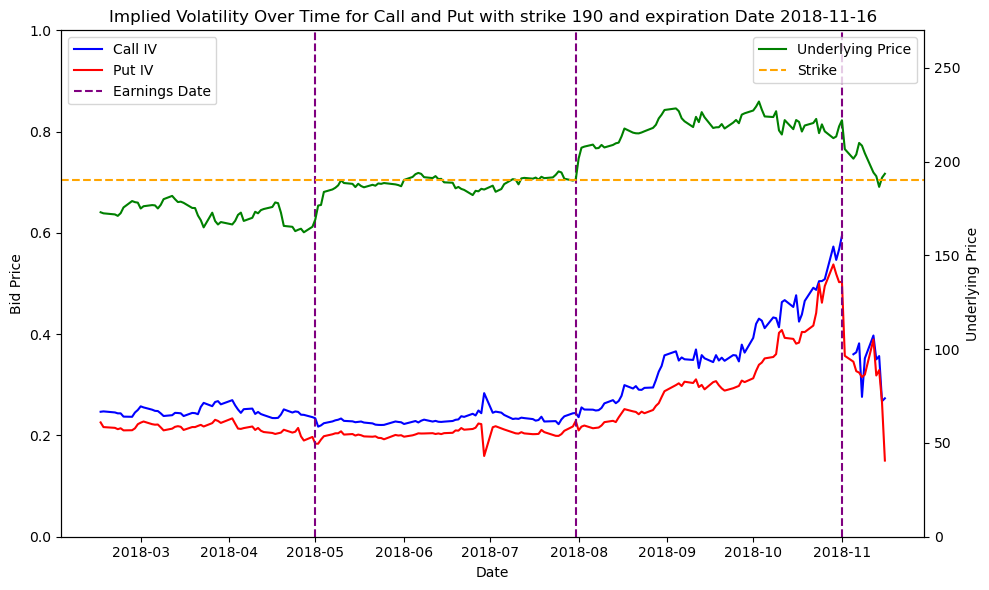

In [38]:
# Filter the DataFrame for the specific OPTION_ID
option_id = 'AAPL20181116_190.0'
filtered_df = options_df[options_df['OPTION_ID'] == option_id]

# Create a figure and the first subplot (left y-axis)
fig, ax1 = plt.subplots(figsize=(10, 6))


# Plotting the option bid prices on the left y-axis
ax1.plot(filtered_df['QUOTE_DATE'], filtered_df['C_IV'], linestyle='-', color='b', label='Call IV')
ax1.plot(filtered_df['QUOTE_DATE'], filtered_df['P_IV'], linestyle='-', color='r', label='Put IV')



label = 'yes'
for earning_date in earnings_dates:
    if str(earning_date) > '2018-03-01' and str(earning_date) < '2019-01-01':
        ax1.axvline(x=earning_date, color='purple', linestyle='--', label='Earnings Date' if label == 'yes' else None)
        label = 'no'

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Bid Price')
ax1.set_title(f'Implied Volatility Over Time for Call and Put with strike 190 and expiration Date 2018-11-16')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

# Plot the underlying price on the right y-axis
ax2.plot(filtered_df['QUOTE_DATE'], filtered_df['UNDERLYING_LAST'], color='g', label='Underlying Price')
ax2.axhline(y=190, color='orange', linestyle='--', label='Strike')

# Set labels for the right y-axis
ax2.set_ylabel('Underlying Price')

# Set the legend for the right y-axis
ax2.legend(loc='upper right')

ax2.set_ylim(0, 270)
ax1.set_ylim(0, 1)


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Ensure the layout is tight
plt.tight_layout()

# Show the plot
plt.show()

**Key Insights:**


**1. Bid Price Trends for Call and Put Options** 
- The chart illustrates that the bid price of call options (blue line) consistently remains lower than that of put options (red line) over the observed period. This suggests that investors are willing to pay more for put options, which provide downside protection.

**2. Earnings Date Impact**
- Earnings dates, represented by vertical purple dashed lines, have a noticeable impact on option bid prices. Before earnings announcements, there is often a rise in implied volatility, leading to higher option premiums.
- After earnings announcements, there can be significant price swings in both call and put options. These price movements may reflect changes in market expectations or reactions to earnings results.

**3. Relationship with Underlying Price and Strike Price**
- The green line represents the price of the underlying asset, likely a stock. It fluctuates over time.
- The orange dashed line represents the strike price of the options (190). The distance between the green line (underlying price) and the orange dashed line (strike price) indicates whether the options are in-the-money (ITM), at-the-money (ATM), or out-of-the-money (OTM).
- For example, when the green line is below the orange dashed line, call options are ITM, while put options are OTM.

**4. Bid Price Volatility**
- Both call and put option bid prices exhibit volatility, with noticeable fluctuations over time. This volatility can result from changes in factors like market sentiment, implied volatility, and supply and demand dynamics for these options.


**5. Risk Management Consideration**
- Given the bid price volatility observed around earnings dates, risk management strategies are crucial when trading options. 


In summary, these charts are a valuable tool for assessing historical bid price and IV trends of call and put options, with a focus on their response to earnings events and underlying asset price movements. 

In [ ]:
## IV Changes

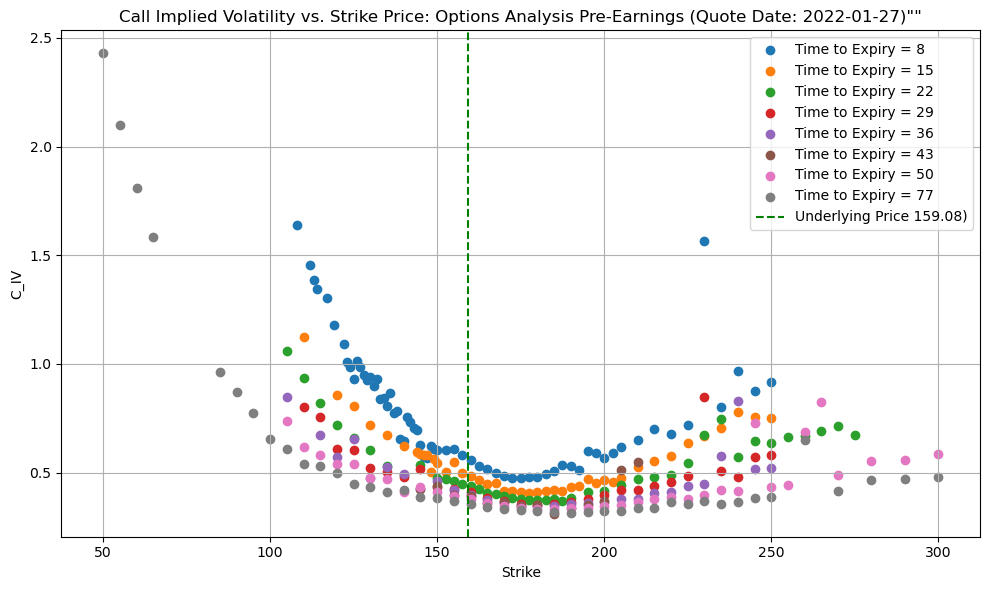

In [41]:
samp= [x for x in range(2,100)]
# Filter the DataFrame for options with TIME_TO_EXPIRY equal to 20 or 40 and quote date equal to '2022-01-27'
filtered_options = options_df[(options_df['DAYS_TO_EXPIRATION'].isin(samp)) & (options_df['QUOTE_DATE'] == '2022-01-27')]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Separate the data by TIME_TO_EXPIRY and plot each separately
for time_to_expiry, group in filtered_options.groupby('DAYS_TO_EXPIRATION'):
    plt.scatter(group['STRIKE'], group['C_IV'], marker='o', label=f'Time to Expiry = {time_to_expiry}')

# Drop rows with NaN values in C_IV or STRIKE columns
filtered_options = filtered_options.dropna(subset=['C_IV', 'STRIKE'])


# Set labels and title
plt.xlabel('Strike')
plt.ylabel('C_IV')
plt.title('Call Implied Volatility vs. Strike Price: Options Analysis Pre-Earnings (Quote Date: 2022-01-27)""')

# Vertical line representing the underlying price at '2022-01-27'
underlying_price_at_date = filtered_options.iloc[0]['UNDERLYING_LAST']
plt.axvline(x=underlying_price_at_date, color='g', linestyle='--', label=f'Underlying Price {underlying_price_at_date:.2f})')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

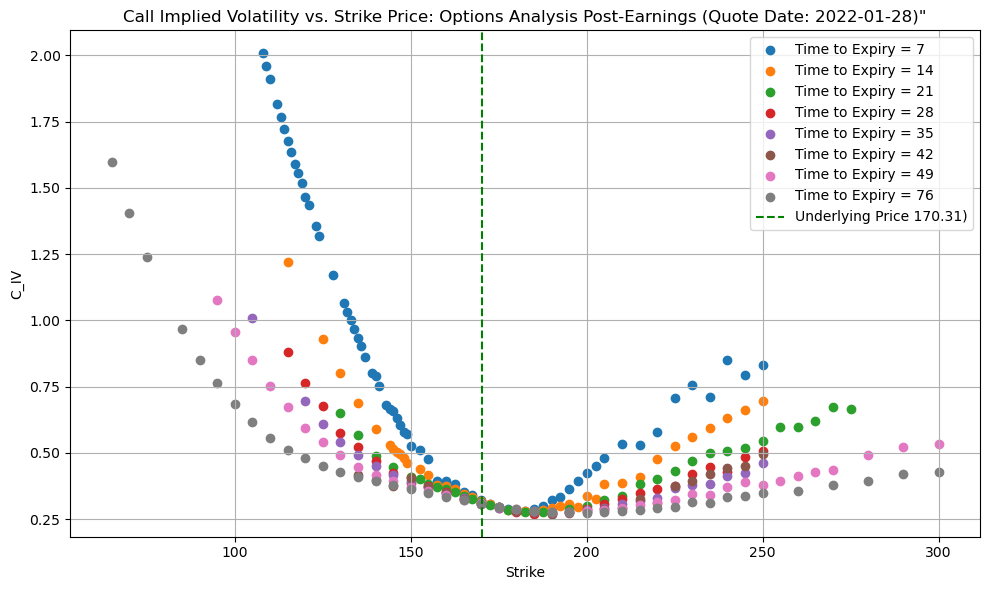

In [40]:
samp= [x for x in range(1,100)]
# Filter the DataFrame for options with TIME_TO_EXPIRY equal to 20 or 40 and quote date equal to '2022-01-27'
filtered_options = options_df[(options_df['DAYS_TO_EXPIRATION'].isin(samp)) & (options_df['QUOTE_DATE'] == '2022-01-28')]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Separate the data by TIME_TO_EXPIRY and plot each separately
for time_to_expiry, group in filtered_options.groupby('DAYS_TO_EXPIRATION'):
    plt.scatter(group['STRIKE'], group['C_IV'], marker='o', label=f'Time to Expiry = {time_to_expiry}')

# Drop rows with NaN values in C_IV or STRIKE columns
filtered_options = filtered_options.dropna(subset=['C_IV', 'STRIKE'])

# Set labels and title
plt.xlabel('Strike')
plt.ylabel('C_IV')
plt.title('Call Implied Volatility vs. Strike Price: Options Analysis Post-Earnings (Quote Date: 2022-01-28)"')

# Vertical line representing the underlying price at '2022-01-27'
underlying_price_at_date = filtered_options.iloc[0]['UNDERLYING_LAST']
plt.axvline(x=underlying_price_at_date, color='g', linestyle='--', label=f'Underlying Price {underlying_price_at_date:.2f})')


# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

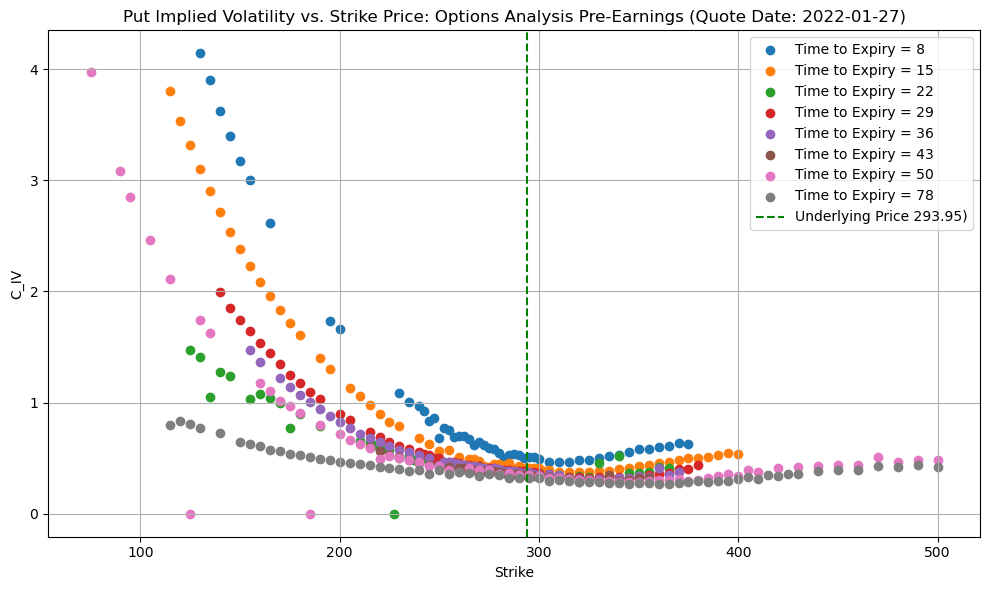

In [42]:
samp= [x for x in range(2,100)]
# Filter the DataFrame for options with TIME_TO_EXPIRY equal to 20 or 40 and quote date equal to '2022-01-27'
filtered_options = options_df[(options_df['DAYS_TO_EXPIRATION'].isin(samp)) & (options_df['QUOTE_DATE'] == '2020-04-30')]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Separate the data by TIME_TO_EXPIRY and plot each separately
for time_to_expiry, group in filtered_options.groupby('DAYS_TO_EXPIRATION'):
    plt.scatter(group['STRIKE'], group['C_IV'], marker='o', label=f'Time to Expiry = {time_to_expiry}')

# Drop rows with NaN values in C_IV or STRIKE columns
filtered_options = filtered_options.dropna(subset=['C_IV', 'STRIKE'])


# Set labels and title
plt.xlabel('Strike')
plt.ylabel('C_IV')
plt.title('Put Implied Volatility vs. Strike Price: Options Analysis Pre-Earnings (Quote Date: 2022-01-27)')

# Vertical line representing the underlying price at '2022-01-27'
underlying_price_at_date = filtered_options.iloc[0]['UNDERLYING_LAST']
plt.axvline(x=underlying_price_at_date, color='g', linestyle='--', label=f'Underlying Price {underlying_price_at_date:.2f})')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

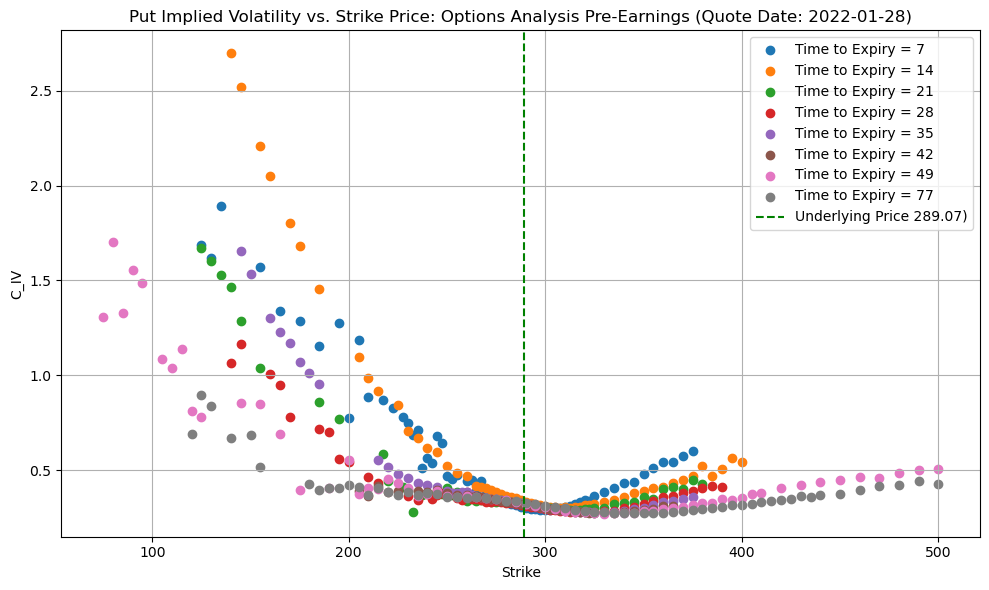

In [43]:
samp= [x for x in range(1,100)]
# Filter the DataFrame for options with TIME_TO_EXPIRY equal to 20 or 40 and quote date equal to '2022-01-27'
filtered_options = options_df[(options_df['DAYS_TO_EXPIRATION'].isin(samp)) & (options_df['QUOTE_DATE'] == '2020-05-01')]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Separate the data by TIME_TO_EXPIRY and plot each separately
for time_to_expiry, group in filtered_options.groupby('DAYS_TO_EXPIRATION'):
    plt.scatter(group['STRIKE'], group['C_IV'], marker='o', label=f'Time to Expiry = {time_to_expiry}')

# Drop rows with NaN values in C_IV or STRIKE columns
filtered_options = filtered_options.dropna(subset=['C_IV', 'STRIKE'])

# Set labels and title
plt.xlabel('Strike')
plt.ylabel('C_IV')
plt.title('Put Implied Volatility vs. Strike Price: Options Analysis Pre-Earnings (Quote Date: 2022-01-28)')

# Vertical line representing the underlying price at '2022-01-27'
underlying_price_at_date = filtered_options.iloc[0]['UNDERLYING_LAST']
plt.axvline(x=underlying_price_at_date, color='g', linestyle='--', label=f'Underlying Price {underlying_price_at_date:.2f})')


# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plots above provide valuable insights into the behavior of implied volatility around earnings announcements. Here's an interpretation of the IV changes for call and put options:

1. **Pre-Earnings Anticipation (Higher IV):**
   - Before earnings releases, both call and put options exhibit higher implied volatility (IV).
   - This elevated IV is often a result of market participants' anticipation of increased uncertainty and potential price swings associated with earnings announcements.
   - Traders and investors are willing to pay higher premiums for options during this period due to the uncertainty.

2. **Post-Earnings IV Reduction (Lower IV):**
   - Following earnings releases, there is a noticeable reduction in implied volatility for both call and put options.
   - This phenomenon is commonly referred to as the "volatility crush."
   - Reduced IV implies decreased expected price volatility, which is consistent with the market's reaction to the earnings information.
   - The decline in IV can lead to lower option premiums.

3. **Differences Between Call and Put Options:**
   - The behavior of call and put options is generally similar in terms of IV changes around earnings.
   - Both call and put options experience elevated IV before earnings and a subsequent decrease in IV afterward.
   - The extent of IV changes may vary depending on factors such as strike price and moneyness.

4. **Strategic Implications:**
   - Traders and investors should be aware of these IV dynamics when planning options strategies around earnings events.
   - Buying options before earnings can be expensive due to high IV, requiring a more significant price move to be profitable.
   - Conversely, selling options before earnings can benefit from the IV reduction post-earnings.



# Conclusions

In this project, my primary objective was to demonstrate my proficiency in several key areas, including data analysis, Python programming, web scraping, and data visualization. I embarked on a descriptive journey, aiming to provide an initial understanding of the dataset and its potential insights. Let's recap my main achievements:

## 1. Data Collection and processing

I started by showcasing my web scraping skills to gather valuable financial data. This process involved extracting information from online sources, structuring it, and preparing it for analysis. My ability to collect and clean data efficiently is a fundamental skill for any data analyst.

### The Power of Data Cleaning and Preprocessing

The importance of data cleaning and preprocessing cannot be overstated. It forms the foundation of any successful data analysis project. During this project, I meticulously cleaned and processed the dataset to ensure its quality and integrity. This included:

- **Handling Missing Data:** I addressed missing data points by employing techniques such as imputation or removal, ensuring that my analyses were based on complete and reliable information.

- **Standardization:** I standardized data formats and units, allowing for meaningful comparisons and calculations across various data sources.

- **Outlier Detection:** Identifying and managing outliers helped me prevent skewed results and biased conclusions.

- **Data Transformation:** I applied transformations when necessary, such as converting data types, scaling features, or encoding categorical variables, to make the dataset more amenable to analysis.


## 2. Data Visualization

I recognized the importance of visualizing data effectively to communicate my findings. Through Python libraries such as Matplotlib and Seaborn, I created a range of charts and plots. These visualizations brought my data to life, making it easier to comprehend and interpret.

## Project Outcomes

While my project provided a descriptive overview of the dataset and highlighted several interesting patterns and trends, it's important to note that this is just the beginning. A more extensive quantitative analysis is required to extract deeper and more valuable insights from the data.

## Future Directions

To enhance the scope and impact of this project, future work could include:

- **Quantitative Analysis:** Conducting advanced statistical analyses, regression modeling, and hypothesis testing to uncover relationships and predictive insights within the financial data.

- **Machine Learning:** Implementing machine learning algorithms to make predictive forecasts, risk assessments, or trading strategies based on historical data patterns.

- **Data Enrichment:** Incorporating additional data sources, such as macroeconomic indicators or news sentiment analysis, to provide a more comprehensive context for financial analysis.

- **Interactive Dashboards:** Developing interactive data dashboards that allow users to explore and visualize financial data dynamically.

In conclusion, this project has showcased my abilities in data analysis, Python programming, web scraping, and data visualization. It has provided valuable insights into financial trends and patterns, setting the stage for more in-depth quantitative analysis. As a data analyst, I recognize the importance of continuous exploration and refinement to extract actionable insights and drive informed decision-making in the financial domain.
